<a href="https://colab.research.google.com/github/wlsisl/ESAA_22-2/blob/main/classification_exercise2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 08 분류 실습- 캐글 산탄데르 고객 만족 예측 (Santander_Customer_Satisfaction)

고객 만족 여부를 XGBoost와 LightGBM을 활용해 예측해보자. 

1: 불만 가진 고객

0: 만족한 고객

#### 데이터 전처리

XGBoost는 사이킷런 래퍼를 이용

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from google.colab import drive
drive.mount('/content/drive')

cust_df=pd.read_csv('/content/drive/MyDrive/ESAA_YB/train_santander.csv',encoding='latin-1')
print('dataset shape:',cust_df.shape)
cust_df.head(3)

Mounted at /content/drive
dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [2]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


-> 111개의 피처가 float형, 260개 피처가 int형으로 모두 숫자형이고 null값은 없다. 

In [3]:
#만족 불만족 비율 살펴보기
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt=cust_df[cust_df['TARGET']==1].TARGET.count()
total_cnt=cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt/total_cnt)))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


In [4]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


-> var3칼럼의 경우 min값이 -999999이다. NAN이나 특정 예외 값을 -99999로 변환했을 것이다. 이 값이 116개가 있음을 알 수 있다. 
* **다른 값에 비해 편차가 매우 심하므로 가장 값이 많은 2로 변환하겠다.**
* ID피처는 단순 식별자에 불과하므로 피처에서 드롭
* 클래스 데이터 세트와 피처 데이터 세트를 분리해 별도의 데이터 세트로 별도로 저장

In [5]:
cust_df['var3'].replace(-999999,2,inplace=True)
cust_df.drop('ID',axis=1,inplace=True)

#피처 세트와 레이블 세트 분리, 레이블 칼럼은 DataFrame의 맨 마지막에 위치해 칼럼 위치 -1로 분리
X_features=cust_df.iloc[:,:-1]
y_labels=cust_df.iloc[:,-1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


- 학습과 성능 평가를 위해서 원본 데이터 세트에서 학습 데이터 세트와 테스트 데이터 세트를 분리.

In [6]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X_features,y_labels,
                                                 test_size=0.2,random_state=0)

# 비대칭적 데이터 세트이므로 클래스인 target 값 분포도가 학습/테스트 데이터 세트에 모두 비슷하게 추출됐는지 확인하기
train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 shape: {0}, 테스트 세트 shape: {1}'.format(X_train.shape, X_test.shape))

print('학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')

학습 세트 shape: (60816, 369), 테스트 세트 shape: (15204, 369)
학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

 테스트 세트 레이블 값 분포 비율


-> 학습과 테스트 데이터 세트 모두 TARGET의 값의 분퐉 원본 데이터와 유사하게 전체 데이터의 4%정도의 불만족값으로 만들어짐

### XGBoost 모델 학습과 하이퍼 파라미터 튜닝



In [7]:
from xgboost.sklearn import XGBClassifierBase
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

#n_estimators는 500으로, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정
xgb_clf=XGBClassifier(n_estimators=500,random_state=156)

#성능평가 지표로 auc, 조기 중단 파라미터는 100으로 설정하고 학습 수행
xgb_clf.fit(X_train,y_train,early_stopping_rounds=100,eval_metric='auc',eval_set=[(X_train,y_train),(X_test,y_test)])
xgb_roc_score=roc_auc_score(y_test,xgb_clf.predict_proba(X_test)[:,1],average='macro')

print('ROC AUC:{0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.799928	validation_1-auc:0.803548
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.802222	validation_1-auc:0.805222
[2]	validation_0-auc:0.80819	validation_1-auc:0.813162
[3]	validation_0-auc:0.8127	validation_1-auc:0.813243
[4]	validation_0-auc:0.81648	validation_1-auc:0.816979
[5]	validation_0-auc:0.816018	validation_1-auc:0.816629
[6]	validation_0-auc:0.816474	validation_1-auc:0.817776
[7]	validation_0-auc:0.818148	validation_1-auc:0.818464
[8]	validation_0-auc:0.81806	validation_1-auc:0.818295
[9]	validation_0-auc:0.817039	validation_1-auc:0.818087
[10]	validation_0-auc:0.818318	validation_1-auc:0.818749
[11]	validation_0-auc:0.818711	validation_1-auc:0.818521
[12]	validation_0-auc:0.818673	validation_1-auc:0.818516
[13]	validation_0-auc:0.819156	validation_1-auc:0.818998
[14]	validation_0-auc:0.819847	validation_1-auc:0.81999
[15

-> 테스트 데이터 세트로 예측시 ROC AUC는 약 0.8419이다. 

* 이제 XGBoost의 하이퍼 파라미터 튜닝 수행

  -칼럼의 개수가 많으므로 과적합 가능성을 가정하고 max_depth, min_child_weight, colsample_bytree하이퍼 파라미터만 일자 튜닝 대상으로 설정

**학습시간이 많이 필요한 ML모델인 경우 하이퍼 파라미터 튜닝을 수행하는 요령
 먼저 2 ~ 3개 정도의 파라미터를 결합해 최적 파라미터를 찾아낸 뒤에 이를 기반으로 1~개 파라미터를 결합해 파라미터 튜닝 수행




In [ ]:

from sklearn.model_selection import GridSearchCV
#하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
xgb_clf=XGBClassifier(n_estimators=100)

params={'max depth':[5,7],'min_child_weight':[1,3],'colsample_bytree':[0.5,0.75]}

#cv는 3으로 지정
gridcv=GridSearchCV(xgb_clf,param_grid=params,cv=3)
gridcv.fit(X_train,y_train,early_stopping_rounds=30,eval_metric='auc',eval_set=[(X_train,y_train),(X_test,y_test)])

print('GridSearchCV의 최적 파라미터:',gridcv.best_params_)

xgb_roc_score=roc_auc_score(y_test,gridcv.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC:{0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.689367	validation_1-auc:0.701839
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.792336	validation_1-auc:0.798398
[2]	validation_0-auc:0.789095	validation_1-auc:0.800069
[3]	validation_0-auc:0.793323	validation_1-auc:0.805475
[4]	validation_0-auc:0.802541	validation_1-auc:0.81157
[5]	validation_0-auc:0.799073	validation_1-auc:0.8093
[6]	validation_0-auc:0.798946	validation_1-auc:0.809122
[7]	validation_0-auc:0.803144	validation_1-auc:0.813628
[8]	validation_0-auc:0.807818	validation_1-auc:0.815817
[9]	validation_0-auc:0.809204	validation_1-auc:0.817484
[10]	validation_0-auc:0.809742	validation_1-auc:0.817683
[11]	validation_0-auc:0.811012	validation_1-auc:0.819432
[12]	validation_0-auc:0.817156	validation_1-auc:0.82296
[13]	validation_0-auc:0.811633	validation_1-auc:0.817751
[14]	validation_0-auc:0.812406	validation_1-auc:0.818463
[1

-> 이전 예제의 ROC-AUC가 약 0.8419에서 0.8448로 개선되었다. 

다시 최적 파라미터로 설정한 뒤 n_estimators를 증가시키고 learning_rate를 감소시키고 reg_alpha를 추가하여 XGBClassifier를 학습시킨 뒤 ROC AUC구해보자.

In [ ]:
#n_estimators는 100으로 증가시키고, learning_rate=0.02로 감소, reg_alpha=0.03으로 추가
xgb_clf=XGBClassifier(n_estimators=1000,random_state=156,learning_rate=0.01,max_depth=7,min_child_weight=1,colsample_bytree=0.75,reg_alpha=0.03)

#성능 평가 지표를 auc로, 조기 중단 파라미터 값은 200으로 설정하고 학습 수행
xgb_clf.fit(X_train,y_train,early_stopping_rounds=200,eval_metric='auc',eval_set=[(X_train,y_train),(X_test,y_test)])

xgb_roc_score=roc_auc_score(y_test,xgb_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC:{0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.82311	validation_1-auc:0.815226
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[1]	validation_0-auc:0.825169	validation_1-auc:0.816636
[2]	validation_0-auc:0.830459	validation_1-auc:0.820086
[3]	validation_0-auc:0.834439	validation_1-auc:0.824508
[4]	validation_0-auc:0.836617	validation_1-auc:0.826481
[5]	validation_0-auc:0.836614	validation_1-auc:0.827615
[6]	validation_0-auc:0.837176	validation_1-auc:0.827294
[7]	validation_0-auc:0.837216	validation_1-auc:0.82747
[8]	validation_0-auc:0.838148	validation_1-auc:0.827493
[9]	validation_0-auc:0.838353	validation_1-auc:0.827549
[10]	validation_0-auc:0.839587	validation_1-auc:0.829064
[11]	validation_0-auc:0.839616	validation_1-auc:0.827955
[12]	validation_0-auc:0.839958	validation_1-auc:0.828166
[13]	validation_0-auc:0.84013	validation_1-auc:0.827962
[14]	validation_0-auc:0.841306	validation_1-auc:0.829589


-> ROC AUC가 약 0.8456로 이전 테스트보다 살짝 향상된 결과를 나타낸다. 

XGBoost가 GBM보다는 빠르지만 수행시간이 상당히 많이 요구됨.
앙상블 계열 알고리즘은 과적합이나 잡음에 기본적으로 뛰어난 알고리즘이라서 하이퍼 파라미터 튜닝으로 성능 수치 개선이 급격하게 되는 경우는 많지 않음.

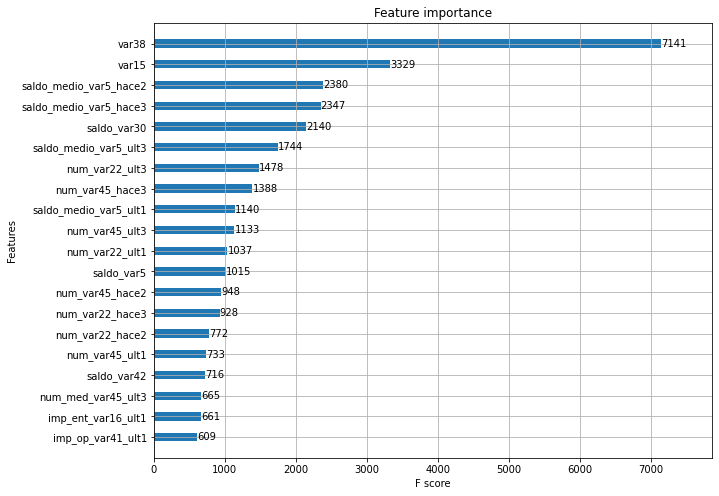

In [ ]:
#튜닝된 모델에서 각 피처의 중요도를 피처 중요도 그래프로 나타내기
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax=plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf,ax=ax,max_num_features=20,height=0.4)

#var38,var15 순으로 XGBoost의 예측 성능을 좌우하는 가장 중요한 피처

### LightGBM 모델 학습과 하이퍼 파라미터 튜닝

앞의 xgboost예제 코드에서 만들어진 데이터 세트를 기반으로 LightGBM학습을 수행하고 roc-auc측정.

In [8]:
from lightgbm import LGBMClassifier

lgbm_clf=LGBMClassifier(n_estimators=500)
evals=[(X_test,y_test)]

lgbm_clf.fit(X_train,y_train,early_stopping_rounds=100,eval_metric='auc',eval_set=evals,verbose=True)

lgbm_roc_score=roc_auc_score(y_test,lgbm_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC:{0:.4f}'.format(lgbm_roc_score))


[1]	valid_0's binary_logloss: 0.165046	valid_0's auc: 0.817384
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.16	valid_0's auc: 0.81863
[3]	valid_0's binary_logloss: 0.156287	valid_0's auc: 0.827411
[4]	valid_0's binary_logloss: 0.153416	valid_0's auc: 0.832175
[5]	valid_0's binary_logloss: 0.151206	valid_0's auc: 0.83481
[6]	valid_0's binary_logloss: 0.149303	valid_0's auc: 0.834721
[7]	valid_0's binary_logloss: 0.147804	valid_0's auc: 0.83659
[8]	valid_0's binary_logloss: 0.146466	valid_0's auc: 0.837602
[9]	valid_0's binary_logloss: 0.145476	valid_0's auc: 0.838114
[10]	valid_0's binary_logloss: 0.144681	valid_0's auc: 0.838472
[11]	valid_0's binary_logloss: 0.143978	valid_0's auc: 0.83808
[12]	valid_0's binary_logloss: 0.14341	valid_0's auc: 0.837771
[13]	valid_0's binary_logloss: 0.142835	valid_0's auc: 0.838063
[14]	valid_0's binary_logloss: 0.142296	valid_0's auc: 0.838485
[15]	valid_0's binary_logloss: 0.141903	valid_0's auc: 0.83

-> XGBoost보다 시간 조금 더 단축됐음.

* GridSearchCV로 좀 더 다양한 하이퍼 파라미터에 대한 튜닝 수행

In [9]:
from sklearn.model_selection import GridSearchCV

#하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 200으로 감소

lgbm_clf=LGBMClassifier(n_estimators=200)

params={'num_leaves':[32,64],
        'max_depth':[128,160],
        'min_child_samples':[60,100],
        'subsample':[0.8,1]}

#cv는 3으로 지정
gridcv=GridSearchCV(lgbm_clf,param_grid=params,cv=3)
gridcv.fit(X_train,y_train,early_stopping_rounds=30,eval_metric='auc',eval_set=[(X_train,y_train),(X_test,y_test)])

print('GridSearchCV 최적 파라미터:',gridcv.best_params_)
lgbm_roc_score=roc_auc_score(y_test,gridcv.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC:{0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's binary_logloss: 0.156085	valid_0's auc: 0.820235	valid_1's binary_logloss: 0.164992	valid_1's auc: 0.81613
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's binary_logloss: 0.150951	valid_0's auc: 0.825778	valid_1's binary_logloss: 0.159874	valid_1's auc: 0.821835
[3]	valid_0's binary_logloss: 0.147167	valid_0's auc: 0.832192	valid_1's binary_logloss: 0.156391	valid_1's auc: 0.827305
[4]	valid_0's binary_logloss: 0.144132	valid_0's auc: 0.837507	valid_1's binary_logloss: 0.15332	valid_1's auc: 0.8334
[5]	valid_0's binary_logloss: 0.141652	valid_0's auc: 0.842275	valid_1's binary_logloss: 0.150954	valid_1's auc: 0.836036
[6]	valid_0's binary_logloss: 0.139662	valid_0's auc: 0.844971	valid_1's binary_logloss: 0.149041	valid_1's auc: 0.838026
[7]	valid_0's binary_logloss: 0.138002	valid_0's auc: 0.846612	valid_1's binary_logloss: 0.147504	valid_1's auc: 0.837776
[8]	valid_0's binary_logloss: 0.136579	valid_0's auc: 0.848539	valid_1's binary_logloss:

In [10]:
#해당 하이퍼 파라미터를 Lightgbm에 적용하고 다시 학습
lgbm_clf=LGBMClassifier(n_estimators=1000,num_leaves=32,subsample=0.8,min_child_samples=100,max_depth=128)
evals=[(X_test,y_test)]
lgbm_clf.fit(X_train,y_train,early_stopping_rounds=100,eval_metric='auc',eval_set=evals,verbose=True)

lgbm_roc_score=roc_auc_score(y_test,lgbm_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC:{0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's binary_logloss: 0.165016	valid_0's auc: 0.819488
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.159711	valid_0's auc: 0.822387
[3]	valid_0's binary_logloss: 0.156068	valid_0's auc: 0.829542
[4]	valid_0's binary_logloss: 0.153141	valid_0's auc: 0.834917
[5]	valid_0's binary_logloss: 0.150804	valid_0's auc: 0.837871
[6]	valid_0's binary_logloss: 0.148876	valid_0's auc: 0.839548
[7]	valid_0's binary_logloss: 0.147225	valid_0's auc: 0.841812
[8]	valid_0's binary_logloss: 0.14594	valid_0's auc: 0.842382
[9]	valid_0's binary_logloss: 0.144866	valid_0's auc: 0.842811
[10]	valid_0's binary_logloss: 0.143872	valid_0's auc: 0.843186
[11]	valid_0's binary_logloss: 0.14305	valid_0's auc: 0.843465
[12]	valid_0's binary_logloss: 0.142376	valid_0's auc: 0.843222
[13]	valid_0's binary_logloss: 0.141783	valid_0's auc: 0.843564
[14]	valid_0's binary_logloss: 0.141419	valid_0's auc: 0.843389
[15]	valid_0's binary_logloss: 0.141	valid_0's auc: 

### 09 분류 실습 - 캐글 신용카드 사기 검출

<데이터 해석>
* class속성은 매우 불균형한 분포. 
  - 0: 사기가 아닌 정상적인 신용카드 트랜잭션 데이터
  - 1: 신용카드 사기 트랜잭션

### 언더 샘플링과 오버 샘플링의 이해

레이블이 불균형한 분포를 가진 데이터 세트 학습시 예측 성능의 문제가 발생할 수 있음. 이상 건수가 정상 건수에 비해 너무 적기 때문에 발생.

따라서 해결책: 언더 샘플링과 오버 샘플링

1. 언더 샘플링
- 많은 데이터 세트를 적은 데이터 세트 수준으로 감소시키는 방식. 

2. 오버 샘플링
- 이상 데이터와 같이 적은 데이터 세트를 증식하여 학습을 위한 충분한 데이터를 확보하는 방법

* imbalanced-learn : smote를 구현한 대표적인 파이썬 패키지

### 데이터 일차 가공 및 모델 학습/예측/평가

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

card_df=pd.read_csv('/content/drive/MyDrive/ESAA_YB/creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


* TIME피처 데이터 생성 관련한 작업용 속성으로 의미 없으니 제거

* Amount 피처 : 신용카드 트랙잭션 금액
* Class 는 레이블로서 0의 경우 정상, 1의 경우 사기 트랜잭션

In [12]:
from sklearn.model_selection import train_test_split

#인자로 입력받은 DataFrame을 복사한 뒤 Time 칼럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
  df_copy=df.copy()
  df_copy.drop('Time',axis=1,inplace=True)
  return df_copy

* get_train_test_dataset() 은 get_preprocessed_df()를 호출한 뒤 학습 피처/ 레이블 데이터 세트, 테스트 피처/레이블 데이터 세트를 반환함.

* get_train_test_dataset내부에서 train_test_split() 함수를 호출하며, 테스트 데이터 세트를 전체의 30%인 Stratified방식으로 추출해 학습 데이터세트와 테스트 데이터 세트의 레이블 값 분포도를 서로 동일하게 만듦

In [13]:
#사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수
def get_train_test_dataset(df=None):
  #인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
  df_copy=get_preprocessed_df(df)
  #DataFrame의 맨 마지막 칼럼이 레이블, 나머지는 피처들
  X_features=df_copy.iloc[:,:-1]
  y_target=df_copy.iloc[:,-1]
  #train_test_split()으로 학습과 테스트 데이터 분할, stratify=y_target으로 기반 분할
  X_train,X_test,y_train,y_test=train_test_split(X_features,y_target,test_size=0.3,random_state=0,stratify=y_target)
  #학습과 테스트 데이터 세트 반환
  return X_train,X_test,y_train,y_test

X_train,X_test,y_train,y_test=get_train_test_dataset(card_df)

print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0]*100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0]*100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


-> 학습 데이터 레이블의 경우 1값이 0.172%, 테스트 데이터 레이블의 경우 1값이 약 0.173%로 큰 차이가 없이 잘 분할됨.

이제 모델을 만들고 로지스틱 회귀와 LightGBM기반의 모델이 데이터 가공을 수행하면서 예측 성능이 어떻게 변하는지 확인하자.

### 로지스틱 회귀를 이용해 신용 카드 사기 여부 예측

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score
from sklearn.metrics import f1_score,confusion_matrix,precision_recall_curve,roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [15]:
def get_clf_eval(y_test, pred=None, pred_proba=None): #평가 한번에 호출하는 함수
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)

  #ROC-AUC 추가
  roc_auc = roc_auc_score(y_test, pred_proba)

  print('오차행렬')
  print(confusion)
  print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율:{2:.4f}, F1 : {3:.4f}, AUC : {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [18]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba =lr_clf.predict_proba(X_test)[:,1]

#3장에서 사용한 get_clf_eval()함수를 이용해 평가 수행
get_clf_eval(y_test,lr_pred, lr_pred_proba)

오차행렬
[[85281    14]
 [   56    92]]
정확도 : 0.9992, 정밀도 : 0.8679, 재현율:0.6216, F1 : 0.7244, AUC : 0.9609


앞으로 수행할 예제 코드에서 반복적으로 모델을 변경해 학습/예측/평가 할 것이므로 이를 위한 별도의 함수 생성

### 학습/예측/평가를 위한 함수 생성


In [19]:
#인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행
def get_model_train_eval(model,ftr_train=None,ftr_test=None,tgt_train=None,tgt_test=None):
  model.fit(ftr_train,tgt_train)
  pred=model.predict(ftr_test)
  pred_proba=model.predict_proba(ftr_test)[:,1]
  get_clf_eval(tgt_test,pred,pred_proba)

데이터 세트가 극도로 불균형하 ㄴ레이블 값 분포도를 가지고 있으므로 LGBMClassifier객체 생성시 boost_from_average = False로 파라미터 설정

* boost_from_average 의 디폴트 값이 True로 변경됨.

In [20]:
#LightGBM로 모델 학습한 뒤, 별도의 테스트 데이터 세트에서 예측 평가를 수행
from lightgbm import LGBMClassifier
lgbm_clf=LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1,boost_from_average=False)
get_model_train_eval(lgbm_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

오차행렬
[[85289     6]
 [   36   112]]
정확도 : 0.9995, 정밀도 : 0.9492, 재현율:0.7568, F1 : 0.8421, AUC : 0.9797


### 데이터 분포도 변환후 모델 학습/ 예측/ 평가

<왜곡된 분포도를 가지는 데이터를 재가공 한 뒤에 모델을 다시 테스트>

대부분 선형 모델은 중요 피처들의 값이 정규 분포 형태를 유지하는 것을 선호한다. 
이제 중요 피처 값의 분포도를 살펴보자.

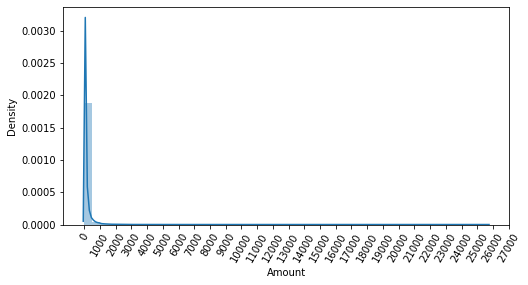

In [21]:
#amount 피처의 분포도 확인
import seaborn as sns
plt.figure(figsize=(8,4))
plt.xticks(range(0,30000,1000),rotation=60)
sns.distplot(card_df['Amount'])

해석 -> 카드 사용금액 1000불 이하인 데이터가 대부분이고 27000불까지 드물지만 많은 금액을 사용한 경우가 발생하면서 꼬리가 긴 형태의 분포 곡선임

<Amount를 표준 정규 분포 형태로 변환한 뒤에 로지스틱 회귀의 예측 성능을 측정해보자.>
* 앞에서 만든 get_processed_df()함수를 다음과 같이 사이킷런의 StandardScaler 클래스를 이용해 Amount피처를 정규 분포 형태로 변환하는 코드로 변경한다.

In [22]:
from sklearn.preprocessing import StandardScaler
#사이킷런의 StandardScaler을 이용해 정규 분포 형태로 Amount 피처값으로 변환하는 로직으로 수정
def get_preprocessed_df(df=None):
  df_copy=df.copy()
  scaler=StandardScaler()
  amount_n=scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
  #변환된 amount를 amount_scaled로 피처명 변경 후 DataFrame 맨 앞 칼럼으로 입력
  df_copy.insert(0,'Amount_Scaled',amount_n)
  #기존 Time,Amount 피처 삭제
  df_copy.drop(['Time','Amount'],axis=1,inplace=True)
  return df_copy

-> 함수를 수정한 후 get_train_test_dataset()을 호출해 학습/테스트 데이터 세트를 생성한 후에 get_model_train_eva()를 이용해 로지스틱 회귀나 LightGBM모델을 각각 학습/예측/평가해보자.

In [23]:
#함수 수정 후 get_train_test_dataset() 호출해 학습/테스트 데이터 세트를 생성한 후에 get_model_train_eval()이용
#Amount를 정규 분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행
X_train,X_test,y_train,y_test=get_train_test_dataset(card_df)

print("###로지스틱 회귀 예측 성능###")
lr_clf=LogisticRegression()
get_model_train_eval(lr_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

print("###LightGBM 예측 성능###")
lgbm_clf=LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1)
get_model_train_eval(lgbm_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

###로지스틱 회귀 예측 성능###
오차행렬
[[85281    14]
 [   58    90]]
정확도 : 0.9992, 정밀도 : 0.8654, 재현율:0.6081, F1 : 0.7143, AUC : 0.9702
###LightGBM 예측 성능###
오차행렬
[[85263    32]
 [  107    41]]
정확도 : 0.9984, 정밀도 : 0.5616, 재현율:0.2770, F1 : 0.3710, AUC : 0.6383


-> 성능이 크게 개선되지는 않음.

이번에는 StandardScaler가 아니라 로그 변환을 수행해보자.
* loglp()함수: 로그 변환의 넘파이함수

In [24]:
def get_preprocessed_df(df=None):
  df_copy=df.copy()
  #넘파이의 log1p()를 이용해 Amount를 로그 변환
  amount_n=np.log1p(df_copy['Amount'])
  df_copy.insert(0,'Amount_Scaled',amount_n)
  df_copy.drop(['Time','Amount'],axis=1,inplace=True)
  return df_copy

In [25]:
#amount 피처를 로그 변환한 후 다시 모델 적용 후 예측 성능 확인
X_train,X_test,y_train,y_test=get_train_test_dataset(card_df)

print("###로지스틱 회귀 예측 성능###")
get_model_train_eval(lr_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

print("###LightGBM 예측 성능###")
get_model_train_eval(lgbm_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

###로지스틱 회귀 예측 성능###
오차행렬
[[85283    12]
 [   59    89]]
정확도 : 0.9992, 정밀도 : 0.8812, 재현율:0.6014, F1 : 0.7149, AUC : 0.9727
###LightGBM 예측 성능###
오차행렬
[[85266    29]
 [   65    83]]
정확도 : 0.9989, 정밀도 : 0.7411, 재현율:0.5608, F1 : 0.6385, AUC : 0.7801


-> 약간씩 성능 개선



---
### 이상치 데이터 제거 후 모델 학습/예측/평가

이상치 데이터는 전체 데이터의 패턴에서 벗어난 이상 값을 가진 데이터이다.

이상치를 찾는 방법 중 하나인 IQR방식에 대해 알아보자.
* IQR방식 : 사분위 값의 편차를 이용하는 기법, 박스플롯으로 시각화
* IQR : Q1과 Q3의 범위
* 최댓값 : Q3  + 1.5 * IQR 
* 최솟값 : Q1 - 1.5 * IQR 
* 이상치 : 최댓값과 최솟값 사이의 이외의 값

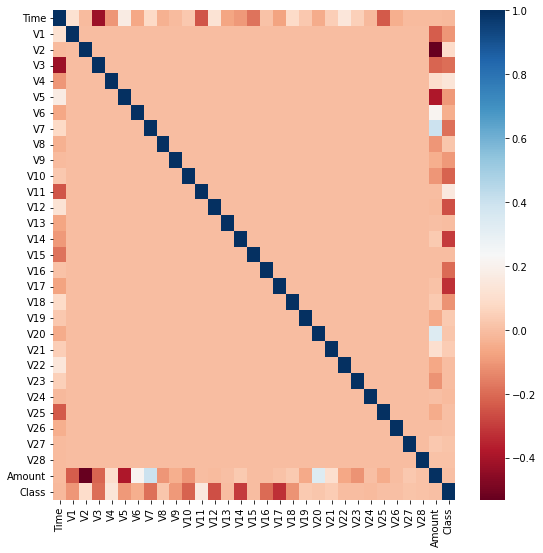

In [26]:
#DataFrame의 corr() 이용해 각 피처별로 상관도를 구한 뒤 시본의 heatmap 통해 시각화
import seaborn as sns

plt.figure(figsize=(9,9))
corr=card_df.corr()
sns.heatmap(corr,cmap='RdBu')

-> 상관관계 히트맵에서 CMAP을 'RdB'로 설정해 양의 상관관계까 높을수록 진한 파란색, 음의 상관관계가 높을수록 진한 빨간색으로 표현

1. 결정 레이블인 class피처와 따라서 음의 상관관계가 가장 높은 피처에 대하여 이상치를 찾아서 제거하기.
 - IQR을 이용해 이상치를 검출하는 함수를 생성한 뒤, 이를 이용해 검출된 이상치 삭제
 - get_outlier()함수 : DataFrame과 이상치를 검출한 칼럼을 입력 받음

In [27]:
import numpy as np

def get_outlier(df=None,column=None,weight=1.5):
  #fraud에 해당하는 column 데이터만 추출, 1/4분위기와 3/4 분위 지점을 np.percentile로 구함
  fraud=df[df['Class']==1][column]
  quantile_25=np.percentile(fraud.values,25)
  quantile_75=np.percentile(fraud.values,75)
  #IQR을 구하고, IQR에 1.5를 곱해 최댓값과 최솟값 지점 구함
  iqr=quantile_75-quantile_25
  iqr_weight=iqr*weight
  lowest_val=quantile_25-iqr_weight
  highest_val=quantile_75+iqr_weight
  #최댓값 보다 크거나, 최솟값 보다 작은 값을 이상치 데이터로 설정하고 DataFrame index 반환
  outlier_index=fraud[(fraud<lowest_val)|(fraud>highest_val)].index
  return outlier_index

In [28]:
#get_outlier함수를 이용해 V14칼럼에서 이상치 데이터를 찾아보기
outlier_index=get_outlier(df=card_df,column='V14',weight=1.5)
print('이상치 데이터 인덱스:',outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [29]:
#이를 삭제하는 로직함수를 추가해 데이터를 가공하기

def get_preprocessed_df(df=None):
  df_copy=df.copy()
  amount_n=np.log1p(df_copy['Amount'])
  df_copy.insert(0,'Amount_Scaled',amount_n)
  df_copy.drop(['Time','Amount'],axis=1,inplace=True)
  #이상치 데이터 삭제하는 로직 추가
  outlier_index=get_outlier(df=df_copy,column='V14',weight=1.5)
  df_copy.drop(outlier_index,axis=0,inplace=True)
  return df_copy

X_train,X_test,y_train,y_test=get_train_test_dataset(card_df)

print("###로지스틱 회귀 예측 성능###")
get_model_train_eval(lr_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

print("###LightGBM 예측 성능###")
get_model_train_eval(lgbm_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

###로지스틱 회귀 예측 성능###
오차행렬
[[85281    14]
 [   48    98]]
정확도 : 0.9993, 정밀도 : 0.8750, 재현율:0.6712, F1 : 0.7597, AUC : 0.9743
###LightGBM 예측 성능###
오차행렬
[[85233    62]
 [  110    36]]
정확도 : 0.9980, 정밀도 : 0.3673, 재현율:0.2466, F1 : 0.2951, AUC : 0.6229


-> 이상치 제거 후 예측 성능 향상

### SMOTE오버 샘플링 적용 후 모델 학습/예측/평가

* 반드시 학습 데이터 세트만 오버 샘플링 하기.

In [30]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train,y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 페처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (199362, 29) (199362,)
SMOTE 적용 후 학습용 페처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 0    199020
1    199020
Name: Class, dtype: int64


-> smote 적용 전 학습 데이터 세트는 199,362건이었지만 적용후 2배 가깝게 증식 되었다. 또 레이블 값이 0과 1의 분포가 동일하게 생성됨.

In [34]:
#로지스틱 회귀 모델을 학습한 뒤 성능 평가
lr_clf = LogisticRegression()
#ftr_train 과 tgt_train 인자값이 SMOTE증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train= X_train_over, ftr_test = X_test, tgt_train = y_train_over, tgt_test = y_test)

오차행렬
[[82937  2358]
 [   11   135]]
정확도 : 0.9723, 정밀도 : 0.0542, 재현율:0.9247, F1 : 0.1023, AUC : 0.9737


-> 재현율이 크게 증가하지만 정밀도가 급격히 저하

이는 로지스틱 회귀 모델이 오버 샘플링으로 인해 실제 원본 데이터의 유형보다 너무나 많은 class=1데이터를 학습하면서 실제 테스트 데이터 세트에서 예측을 지나치게 class=1로 적용해 정밀도가 급격히 떨어지게 된 것이다. 

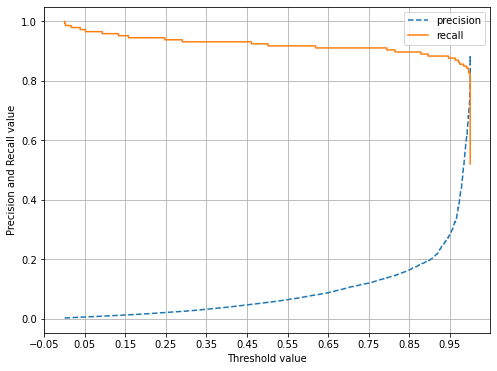

In [43]:
#분류 결정 임곗값에 따른 정밀도와 재현율 곡선을 통해 smote로 학습된 로지스틱 회귀 모델에 어떤 문제가 생기는지 시각적으로 확인하기
from sklearn.metrics import precision_recall_curve

# 곡선으로 시각하는 함수 생성
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
  #threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray추출.
  precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

  #X축을 threshold값으로, y축은 정밀도, 재현율 값으로 각각 plot수행. 정밀도는 점선으로 표시
  plt.figure(figsize=(8,6))
  threshold_boundary = thresholds.shape[0]
  plt.plot(thresholds, precisions[0:threshold_boundary],linestyle='--', label ='precision')
  plt.plot(thresholds, recalls[0:threshold_boundary], label ='recall')

  #threshold 값 X축의 Scale을 0.1 단위로 변경
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start, end, 0.1), 2))

  #x축, y축 label과 legend, 그리고 grid설정
  plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
  plt.legend(); plt.grid()
  plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

->임계값 0.99이하에서 재현율이 매우 좋고 정밀도가 극단적으로 낮다가 0.99이상에서는 반대인 상황 발생. 즉 올바른 예측 모델이 생성되지 못함.

In [36]:
#lightGBM 모델을 SMOTE로 오버 샘플링 된 데이터 세트로 학습/예측/평가를 수행
lgbm_clf=LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1,boost_from_average=False)
get_model_train_eval(lgbm_clf,ftr_train=X_train_over,ftr_test=X_test,tgt_train=y_train_over,tgt_test=y_test)

오차행렬
[[85286     9]
 [   22   124]]
정확도 : 0.9996, 정밀도 : 0.9323, 재현율:0.8493, F1 : 0.8889, AUC : 0.9789


-> 재현율이 이상치만 제거한 경우인 82.88보다 높게 측정됨. 그러나 정밀도는 조금 낮아짐. 원래 smote를 적용할 때 재현율은 높아지나 정밀도는 낮아지는 것이 일반적이다. 